# Assignment 9

In this assignment we'll re-examine the `Road_Casualties_in_Great_Britain_1969___84_434_19.txt` data set from homework 5. 

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. Your work will be manually graded by our TA. 

Protip: if you write your `.stan` file generally enough, it will work with most of the models below, and you won't need to keep recompiling the model object!


In [1]:
import pandas as pd
import numpy as np
import os
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

## Data Description

This is a road safety data set for car drivers in Great Britain killed or seriously injured Jan 1969 to Dec 1984. Each row of data corresponds to one month of time. 

The primary question of interest for us is to determine whether the introduction of seat belt laws saves lives. 

### Explanation of columns:

 - `DriversKilled` : number car drivers killed.
 - `drivers`: total number of drivers killed or seriously injured
 - `front`: front-seat passengers killed or seriously injured.
 - `rear`: rear-seat passengers killed or seriously injured
 - `kms`: distance driven.
 - `PetrolPrice`: the price of gas
 - `VanKilled`: number of van (‘light goods vehicle’) drivers.
 - `law`: was the law in effect that month? $0$ if not, $1$ if it was


In [2]:
road_data = pd.read_csv("Road_Casualties_in_Great_Britain_1969___84_434_19.csv")
road_data.head()

,Unnamed: 0,X,DriversKilled,drivers,front,rear,kms,PetrolPrice,VanKilled,law
0,1,1,107,1687,867,269,9059,0.102972,12,0
1,2,2,97,1508,825,265,7685,0.102363,6,0
2,3,3,102,1507,806,319,9963,0.102062,12,0
3,4,4,87,1385,814,407,10955,0.100873,8,0
4,5,5,119,1632,991,454,11823,0.101020,10,0


In [3]:
road_data = road_data.rename(columns={'Unnamed: 0': 'time'})

## Problem 1:

Recall the arithmetic we did for coming up with an interpretation for the coefficients of a logistic regression model. Perform an analogous derivation for the coefficients of a Poisson regression model. Attach your screenshotted work to this notebook. 



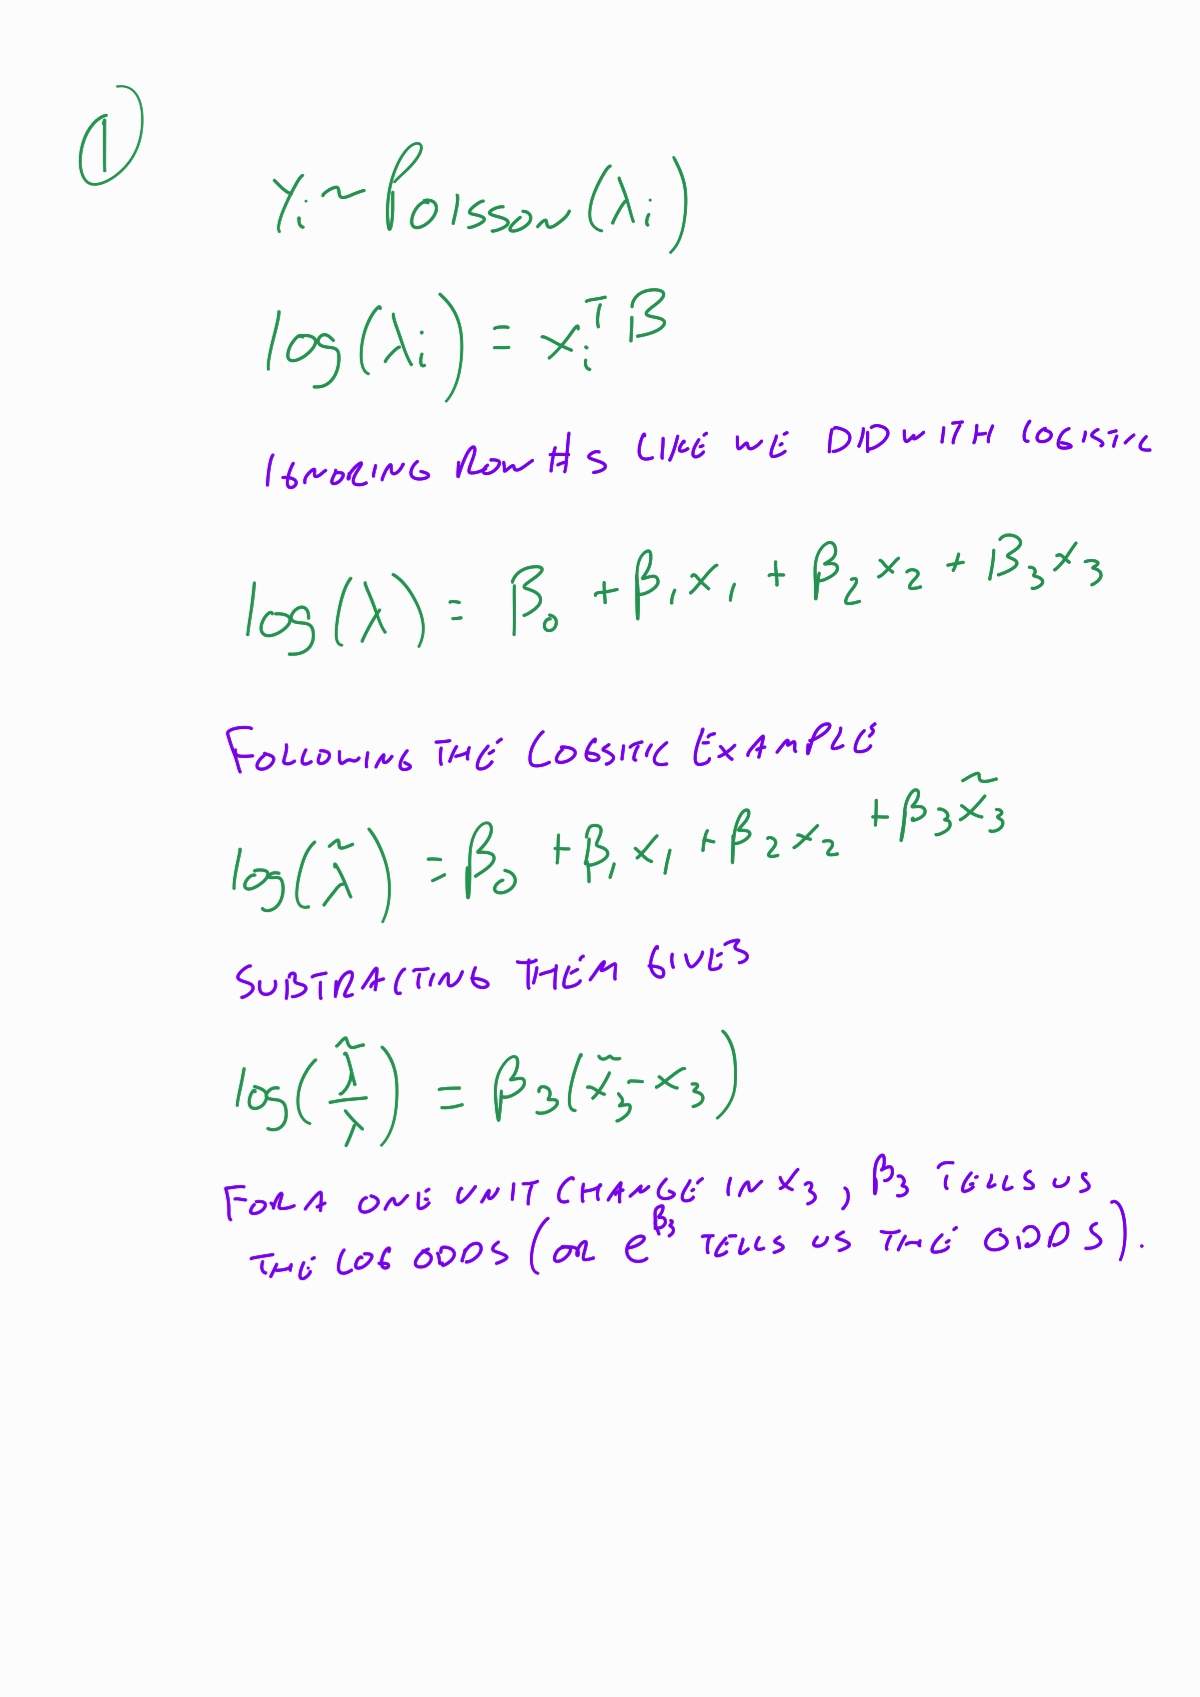

## Problem 2:

Fit the following model. Discuss the posterior you found in detail. 

 - $y$ is the monthly sum of `drivers`, `front`, and `rear`.
 - $x_1$ is `PetrolPrice`
 - $x_2$ is the `law` dummy variable

$$
\log(\lambda) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 
$$

$$
y \mid x_1, x_2 \sim \text{Poisson}(\lambda)
$$

In [4]:
road_data['accidents'] = road_data['drivers'] + road_data['front'] + road_data['rear']
accidents = road_data['accidents']

In [5]:
road_simp = road_data[['PetrolPrice', 'law']]
road_simp.head()

,PetrolPrice,law
0,0.102972,0
1,0.102363,0
2,0.102062,0
3,0.100873,0
4,0.101020,0


In [6]:
model_code = os.path.join('.', 'poisson_log.stan')
model = CmdStanModel(stan_file=model_code)

21:45:02 - cmdstanpy - INFO - compiling stan file /bml24/hw9/poisson_log.stan to exe file /bml24/hw9/poisson_log
21:45:23 - cmdstanpy - INFO - compiled model executable: /bml24/hw9/poisson_log


In [7]:
p2_data = {'N' : road_simp.shape[0], 'K': road_simp.shape[1], 'X': road_simp, 'y':accidents}
fit2 = model.sample(data = p2_data)

21:45:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:45:23 - cmdstanpy - INFO - CmdStan done processing.


In [8]:
fit2.summary().iloc[0:4]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,3.898270e+06,0.108116,4.181280,3.898260e+06,3.898270e+06,3.898270e+06,1495.690,1636.420,0.999429
alpha,8.499680e+00,0.000456,0.012320,8.479220e+00,8.499960e+00,8.520250e+00,731.031,799.815,1.007120
beta[1],-4.886650e+00,0.004524,0.120600,-5.086440e+00,-4.889300e+00,-4.688690e+00,710.559,777.416,1.007060
beta[2],-1.896810e-01,0.000130,0.004834,-1.974880e-01,-1.897480e-01,-1.817980e-01,1391.880,1522.850,1.002470


Text(0.5, 1.0, 'beta 2')

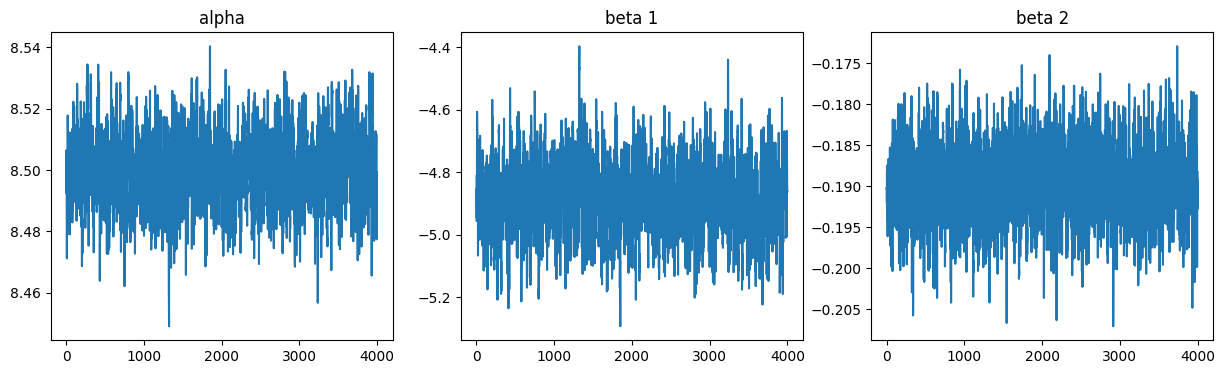

In [9]:
fig2, (p2a, p2b1, p2b2) = plt.subplots(1, 3, figsize=(15,4))

p2a.plot(fit2.draws_pd()['alpha'])
p2a.set_title('alpha')

p2b1.plot(fit2.draws_pd()['beta[1]'])
p2b1.set_title('beta 1')

p2b2.plot(fit2.draws_pd()['beta[2]'])
p2b2.set_title('beta 2')

The posterior has $\hat{R}\$s that are all less than 1.01 and all graph as fuzzy caterpillars. The credible intervals can be found in the summary table. While beta 2 is close to 0 the interval does not include 0. But this may be something to look into.

## Problem 2:

Come up with some posterior (predictive) summary that suggests you might be missing a predictor that has to do with time!


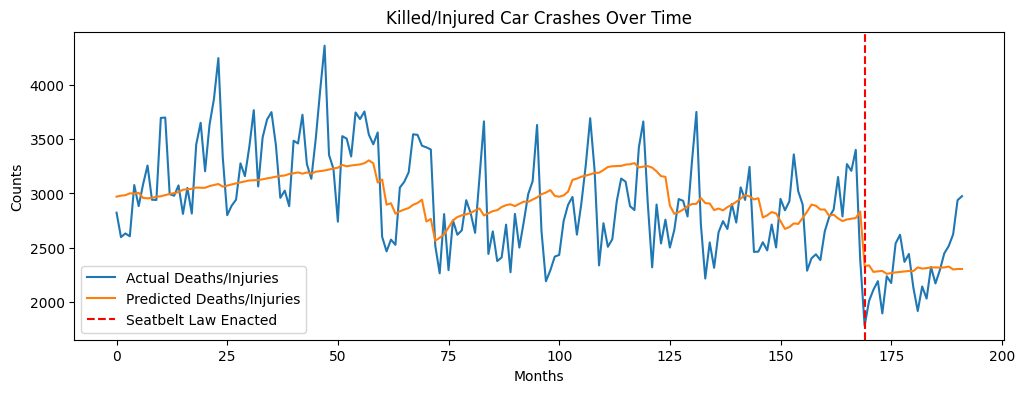

In [10]:
p2a = fit2.draws_pd()['alpha'].mean()
p2b1 = fit2.draws_pd()['beta[1]'].mean()
p2b2 = fit2.draws_pd()['beta[2]'].mean()

y2 = np.exp(p2a + p2b1 * road_simp['PetrolPrice'] + p2b2 * road_simp['law'])
plt.figure(figsize=(12,4))
plt.plot(accidents, label='Actual Deaths/Injuries')
plt.plot(y2, label='Predicted Deaths/Injuries')
plt.axvline(x=169, color='red', linestyle='--', label='Seatbelt Law Enacted')
plt.legend()
plt.title('Killed/Injured Car Crashes Over Time')
plt.xlabel('Months')
plt.ylabel('Counts')
plt.show()

I originally did this outside of stan. That is the plot above. Then I figured I should use the posterior predictive in stan. That plot is below. The only difference is the credible interval to make use of the stan data (I got this idea from Sarah during office hours. I figured I should do something to distinguish using stan verses not, otherwise they'd be the same. I already had both graphs before watching office hours. I went to see about something else and saw thing and thought it added a nice touch.). There is definitely an up and down element in the original data that is not in this predictive data that hints that an element of time is being missed in the curent fit. A line indicating when the seatbelt law was enacted is shown for reference. We can see that the data and the model have a sharp decline near that line.

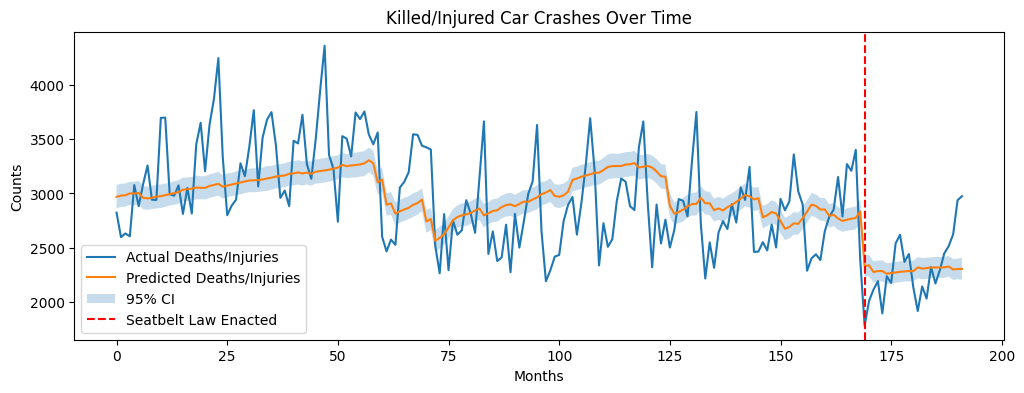

In [11]:
pred2 = fit2.stan_variable('y_tilde')
pred2_mean = pred2.mean(axis=0)
pred2_lower = np.percentile(pred2, 2.5, axis=0) 
pred2_upper = np.percentile(pred2, 97.5, axis=0) 

plt.figure(figsize=(12,4))
plt.plot(accidents, label='Actual Deaths/Injuries')
plt.plot(pred2_mean, label='Predicted Deaths/Injuries')
plt.fill_between(road_data['time']-1, pred2_lower, pred2_upper, alpha=0.25, label='95% CI') 
plt.axvline(x=169, color='red', linestyle='--', label='Seatbelt Law Enacted')
plt.legend(loc='lower left')
plt.title('Killed/Injured Car Crashes Over Time')
plt.xlabel('Months')
plt.ylabel('Counts')
plt.show()

## Problem 3:

Unfortunately, the previous model doesn't not capture any effect that time might have on the accident rate. You might reason accident rates depend on the month. 

Fit the following model. Discuss the posterior you found in detail. 

 - $y$ is the monthly sum of `drivers`, `front`, and `rear`.
 - $x_1$ is `PetrolPrice`
 - $x_2$ is the `law` dummy variable
 - $x_3$ is $1$ if it's February
 - $\vdots$
 - $x_{14}$ is $1$ if it's December

$$
\log(\lambda) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_{14} x_{14}
$$

$$
y \mid x_1, \ldots, x_{14} \sim \text{Poisson}(\lambda)
$$

Notice that you have $11$ new dummy variables. January is our baseline and so does not require one. The first observation is January, and it proceeds sequentially with no missing months.

In [12]:
road_data['X'] = road_data['X'] % 12
road_data = road_data.rename(columns={'X': 'month'})

In [13]:
road_data['month'] = road_data['month'].replace({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                                                 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 0: 'Dec'})
dummies = pd.get_dummies(road_data['month'], dtype='int')
dummies = dummies[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
dummies = dummies.drop('Jan', axis=1)
road_month = pd.concat([road_simp, dummies], axis=1)
road_month.head(15)

,PetrolPrice,law,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,0.102972,0,0,0,0,0,0,0,0,0,0,0,0
1,0.102363,0,1,0,0,0,0,0,0,0,0,0,0
2,0.102062,0,0,1,0,0,0,0,0,0,0,0,0
3,0.100873,0,0,0,1,0,0,0,0,0,0,0,0
4,0.101020,0,0,0,0,1,0,0,0,0,0,0,0
5,0.100581,0,0,0,0,0,1,0,0,0,0,0,0
6,0.103774,0,0,0,0,0,0,1,0,0,0,0,0
7,0.104076,0,0,0,0,0,0,0,1,0,0,0,0
8,0.103774,0,0,0,0,0,0,0,0,1,0,0,0
9,0.103026,0,0,0,0,0,0,0,0,0,1,0,0


In [14]:
p3_data = {'N' : road_month.shape[0], 'K': road_month.shape[1], 'X': road_month, 'y':accidents}
fit3 = model.sample(data = p3_data)

21:45:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:45:39 - cmdstanpy - INFO - CmdStan done processing.


In [15]:
fit3.summary().iloc[0:15]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,3.901190e+06,0.070391,3.403290,3.901190e+06,3.901190e+06,3.901200e+06,2337.570,2213.610,1.000570
alpha,8.435600e+00,0.000428,0.013226,8.413700e+00,8.435770e+00,8.456770e+00,953.390,902.832,1.005850
beta[1],-4.882140e+00,0.003730,0.122879,-5.082520e+00,-4.883410e+00,-4.675350e+00,1085.260,1027.710,1.005600
beta[2],-1.924680e-01,0.000096,0.004939,-2.004900e-01,-1.924590e-01,-1.843040e-01,2620.690,2481.710,1.001870
beta[3],-9.981940e-02,0.000225,0.006959,-1.111780e-01,-9.981950e-02,-8.830930e-02,955.459,904.791,0.999649
beta[4],-4.487330e-02,0.000220,0.006763,-5.584300e-02,-4.485560e-02,-3.386640e-02,945.272,895.144,0.999701
beta[5],-6.510600e-02,0.000219,0.006835,-7.617020e-02,-6.507850e-02,-5.368110e-02,970.873,919.387,1.000630
beta[6],3.423930e-02,0.000226,0.006723,2.313410e-02,3.412490e-02,4.521250e-02,888.046,840.953,1.000030
beta[7],1.073860e-02,0.000213,0.006734,-4.394970e-04,1.087630e-02,2.190510e-02,995.119,942.348,0.999415
beta[8],9.767010e-02,0.000214,0.006702,8.666500e-02,9.765390e-02,1.087160e-01,978.156,926.284,0.999693


Text(0.5, 1.0, 'beta 13')

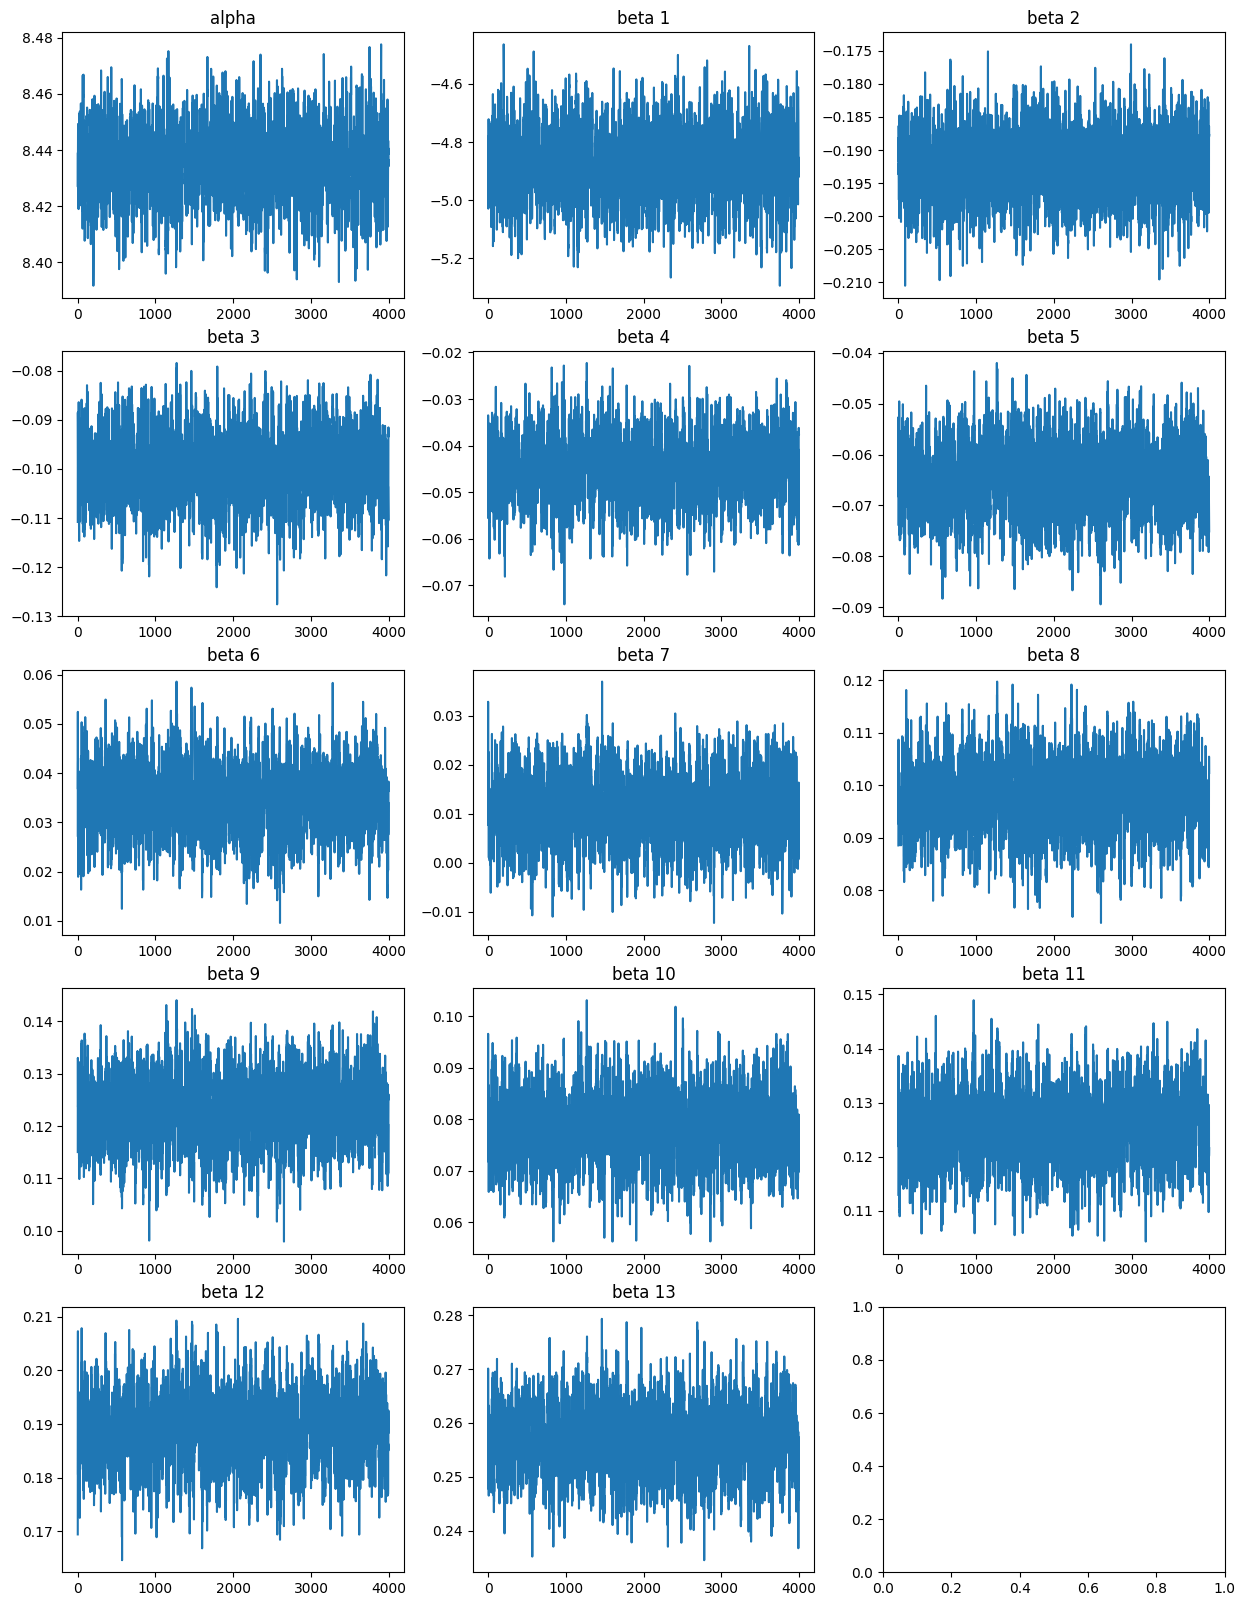

In [16]:
fig3, ax3 = plt.subplots(5, 3, figsize=(15,20))

ax3[0,0].plot(fit3.draws_pd()['alpha'])
ax3[0,0].set_title('alpha')

ax3[0,1].plot(fit3.draws_pd()['beta[1]'])
ax3[0,1].set_title('beta 1')

ax3[0,2].plot(fit3.draws_pd()['beta[2]'])
ax3[0,2].set_title('beta 2')

ax3[1,0].plot(fit3.draws_pd()['beta[3]'])
ax3[1,0].set_title('beta 3')

ax3[1,1].plot(fit3.draws_pd()['beta[4]'])
ax3[1,1].set_title('beta 4')

ax3[1,2].plot(fit3.draws_pd()['beta[5]'])
ax3[1,2].set_title('beta 5')

ax3[2,0].plot(fit3.draws_pd()['beta[6]'])
ax3[2,0].set_title('beta 6')

ax3[2,1].plot(fit3.draws_pd()['beta[7]'])
ax3[2,1].set_title('beta 7')

ax3[2,2].plot(fit3.draws_pd()['beta[8]'])
ax3[2,2].set_title('beta 8')

ax3[3,0].plot(fit3.draws_pd()['beta[9]'])
ax3[3,0].set_title('beta 9')

ax3[3,1].plot(fit3.draws_pd()['beta[10]'])
ax3[3,1].set_title('beta 10')

ax3[3,2].plot(fit3.draws_pd()['beta[11]'])
ax3[3,2].set_title('beta 11')

ax3[4,0].plot(fit3.draws_pd()['beta[12]'])
ax3[4,0].set_title('beta 12')

ax3[4,1].plot(fit3.draws_pd()['beta[13]'])
ax3[4,1].set_title('beta 13')

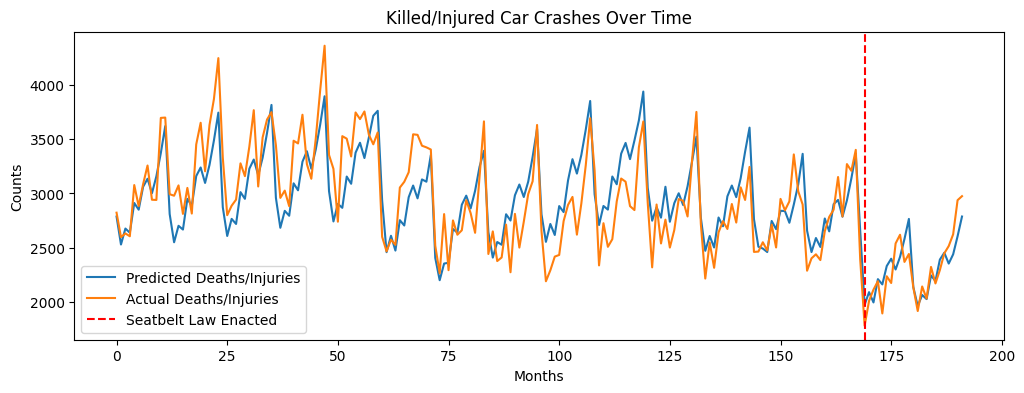

In [17]:
p3a = fit3.draws_pd()['alpha'].mean()
p3b1 = fit3.draws_pd()['beta[1]'].mean()
p3b2 = fit3.draws_pd()['beta[2]'].mean()
p3b3 = fit3.draws_pd()['beta[3]'].mean()
p3b4 = fit3.draws_pd()['beta[4]'].mean()
p3b5 = fit3.draws_pd()['beta[5]'].mean()
p3b6 = fit3.draws_pd()['beta[6]'].mean()
p3b7 = fit3.draws_pd()['beta[7]'].mean()
p3b8 = fit3.draws_pd()['beta[8]'].mean()
p3b9 = fit3.draws_pd()['beta[9]'].mean()
p3b10 = fit3.draws_pd()['beta[10]'].mean()
p3b11 = fit3.draws_pd()['beta[11]'].mean()
p3b12 = fit3.draws_pd()['beta[12]'].mean()
p3b13 = fit3.draws_pd()['beta[13]'].mean()

y3 = np.exp(p3a + p3b1 * road_month['PetrolPrice'] + p3b2 * road_month['law'] + p3b3 * road_month['Feb'] + p3b4 * road_month['Mar'] + p3b5 * road_month['Apr'] + p3b6 * road_month['May'] + p3b7 * road_month['Jun'] + p3b8 * road_month['Jul'] + p3b9 * road_month['Aug'] + p3b10 * road_month['Sep'] + p3b11 * road_month['Oct'] + p3b12 * road_month['Nov'] + p3b13 * road_month['Dec'])
plt.figure(figsize=(12,4))
plt.plot(y3, label='Predicted Deaths/Injuries')
plt.plot(accidents, label='Actual Deaths/Injuries')
plt.axvline(x=169, color='red', linestyle='--', label='Seatbelt Law Enacted')
plt.legend()
plt.title('Killed/Injured Car Crashes Over Time')
plt.xlabel('Months')
plt.ylabel('Counts')
plt.show()

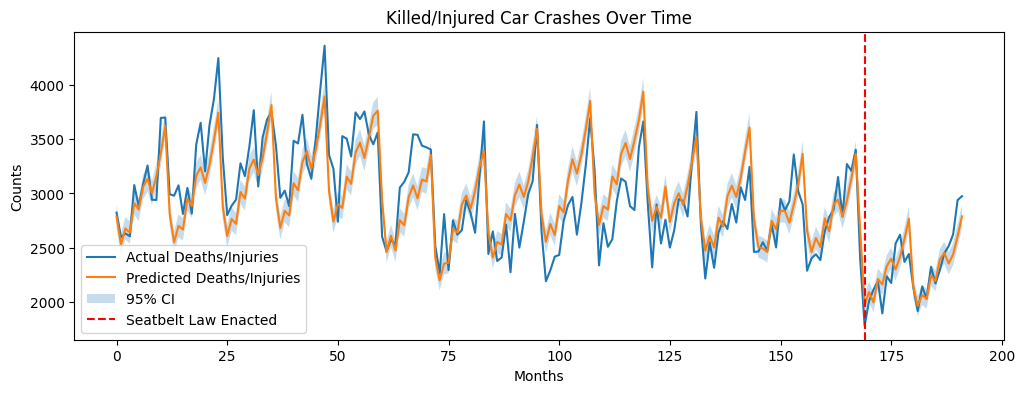

In [18]:
pred3 = fit3.stan_variable('y_tilde')
pred3_mean = pred3.mean(axis=0)
pred3_lower = np.percentile(pred3, 2.5, axis=0) #got this idea from Sarah in the office hours
pred3_upper = np.percentile(pred3, 97.5, axis=0) #figured I should do something to make use of doing it with stan

plt.figure(figsize=(12,4))
plt.plot(accidents, label='Actual Deaths/Injuries')
plt.plot(pred3_mean, label='Predicted Deaths/Injuries')
plt.fill_between(road_data['time']-1, pred3_lower, pred3_upper, alpha=0.25, label='95% CI') 
plt.axvline(x=169, color='red', linestyle='--', label='Seatbelt Law Enacted')
plt.legend(loc='lower left')
plt.title('Killed/Injured Car Crashes Over Time')
plt.xlabel('Months')
plt.ylabel('Counts')
plt.show()

This fits so much better!! The summary table shows all $\hat{R}\$s are less than 1.01 and the credible intervals are there too. There are a number of betas that come close to 0, but only the credible interval from beta 7 contains 0. All present with fuzzy caterpillars. The plot shows this model handles the up and down nature of the number accidents fairly well. This model also portrays a sharp decline near the setabelt law enactment. Once again this plot was done without (the first one) and with (the second one) using stan to generate the posterior predictive.

## Problem 4:

Another way to capture a seasonal affect is to use a sine/cosine wave. This does not require a separate predictor for every month. Consider the following function:

$$
A \cos(2 \pi t \frac{1}{12} + \phi)
$$

 - $A$ is the *amplitude* that stretches to standard cosine wave up or down
 - $1/12$ is the *frequency*. In this case, a cycle is made every $12$ observations (we have monthly data).
 - $\phi$ is the *phase* that adjusts the wave to start at something different than $1$
 - $t = 1,2,\ldots$ is time or in our case the row number

We can visualize this function as a function of $t$. Notice that the distance from peak to peak, from trough to trough is exactly the reciprocal of the frequency. The frequency flipped is called the *period*.

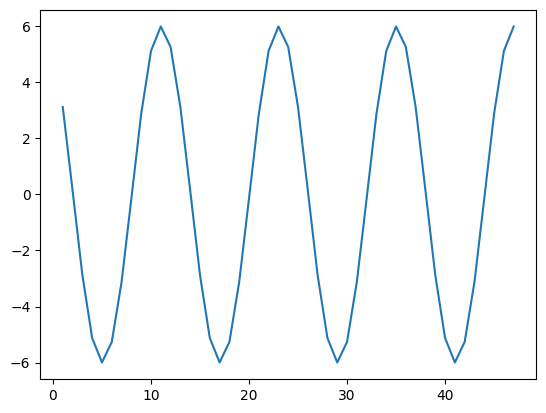

In [19]:
A = 6
phi = 1/2
t = np.arange(1,48)
freq = 1/12
wave = A*np.cos(2*np.pi*freq*t + phi)
plt.plot(t,wave)

The unknown quantities are the phase and the amplitude. If we wanted to estimate these numbers using linear regression, we wouldn't be able to use this expression indirectly. The unknown coefficients are not betas and are not multiplied by the predictor in a linear way.

We could use a nonlinear regression, or we could cleverly use some clever trigonometry to rewrite the above function as

$$
\beta_{3} \cos(2 \pi t [1/12]) + \beta_{4}\sin(2 \pi t [1/12]).
$$

We'll add two predictors. One for $\cos(2 \pi t [1/12])$ and the other for $\sin(2 \pi t [1/12])$. 


Now I can ask you to fit the following model, and discuss the posterior you found. 

$$
\log(\lambda) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_{3} x_{3} + \beta_4 x_4
$$

$$
y \mid x_1, \ldots, x_{4} \sim \text{Poisson}(\lambda)
$$

 - $y$ is the monthly sum of `drivers`, `front`, and `rear`.
 - $x_1$ is `PetrolPrice`
 - $x_2$ is the `law` dummy variable
 - $x_3$ is $\cos(2 \pi t [1/12])$ with $t$ indicating the row number.
 - $x_{4}$ is $\sin(2 \pi t [1/12])$



In [20]:
road_data['cos'] = np.cos(2 * np.pi * road_data.index * (1/12))
road_data['sin'] = np.sin(2 * np.pi * road_data.index * (1/12))
road_trig = road_data[['PetrolPrice', 'law', 'cos', 'sin']]
road_trig.head(13)

,PetrolPrice,law,cos,sin
0,0.102972,0,1.000000e+00,0.000000e+00
1,0.102363,0,8.660254e-01,5.000000e-01
2,0.102062,0,5.000000e-01,8.660254e-01
3,0.100873,0,6.123234e-17,1.000000e+00
4,0.101020,0,-5.000000e-01,8.660254e-01
5,0.100581,0,-8.660254e-01,5.000000e-01
6,0.103774,0,-1.000000e+00,1.224647e-16
7,0.104076,0,-8.660254e-01,-5.000000e-01
8,0.103774,0,-5.000000e-01,-8.660254e-01
9,0.103026,0,-1.836970e-16,-1.000000e+00


In [21]:
p4_data = {'N' : road_trig.shape[0], 'K': road_trig.shape[1], 'X': road_trig, 'y':accidents}
fit4 = model.sample(data = p4_data)

21:46:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:46:02 - cmdstanpy - INFO - CmdStan done processing.


In [22]:
fit4.summary().iloc[0:6]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,3.899980e+06,0.007044,0.446822,3.899980e+06,3.899980e+06,3.899980e+06,4023.520,4888.85,NaN
alpha,8.489420e+00,0.000380,0.011560,8.470390e+00,8.489130e+00,8.508760e+00,927.020,1126.39,1.002910
beta[1],-4.816390e+00,0.003741,0.113948,-5.005220e+00,-4.814860e+00,-4.629560e+00,927.953,1127.52,1.002760
beta[2],-1.906860e-01,0.000112,0.004865,-1.988830e-01,-1.907810e-01,-1.827530e-01,1883.450,2288.52,0.999947
beta[3],-4.856840e-03,0.000029,0.001903,-7.981980e-03,-4.862220e-03,-1.649650e-03,4365.180,5303.99,1.000310
beta[4],-1.109940e-01,0.000031,0.001894,-1.140710e-01,-1.109980e-01,-1.078590e-01,3709.970,4507.86,1.000850


Text(0.5, 1.0, 'beta 4')

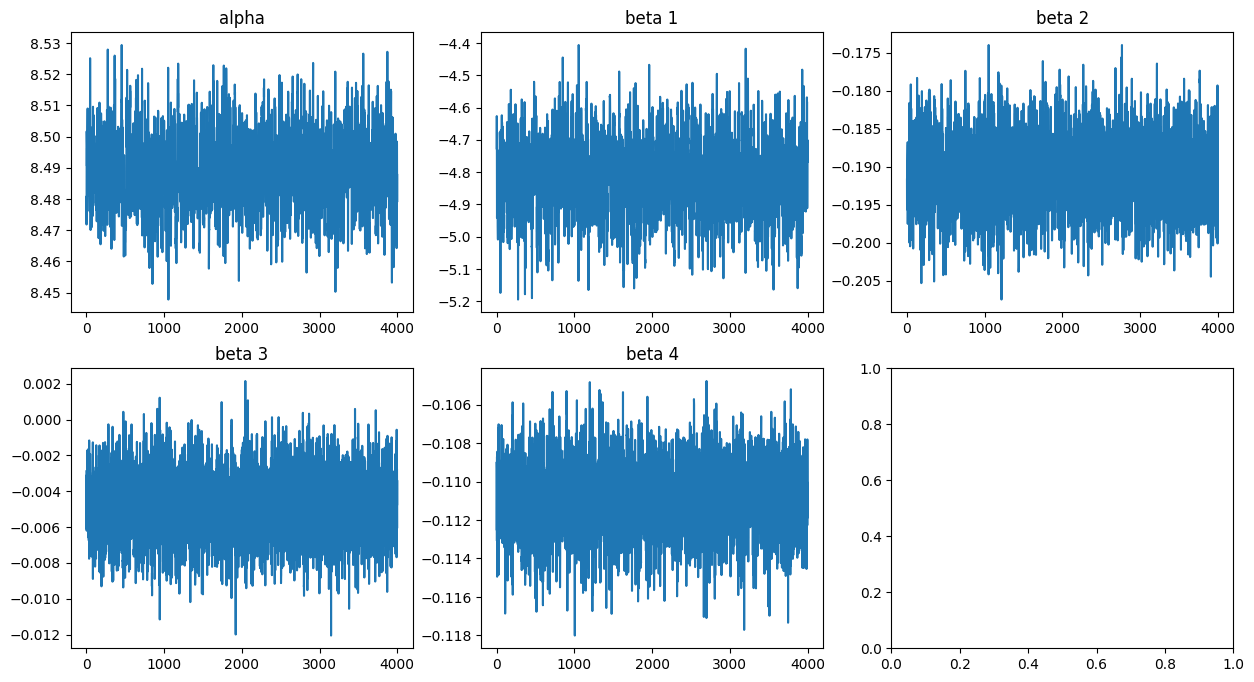

In [23]:
fig4, ax4 = plt.subplots(2, 3, figsize=(15,8))

ax4[0,0].plot(fit4.draws_pd()['alpha'])
ax4[0,0].set_title('alpha')

ax4[0,1].plot(fit4.draws_pd()['beta[1]'])
ax4[0,1].set_title('beta 1')

ax4[0,2].plot(fit4.draws_pd()['beta[2]'])
ax4[0,2].set_title('beta 2')

ax4[1,0].plot(fit4.draws_pd()['beta[3]'])
ax4[1,0].set_title('beta 3')

ax4[1,1].plot(fit4.draws_pd()['beta[4]'])
ax4[1,1].set_title('beta 4')

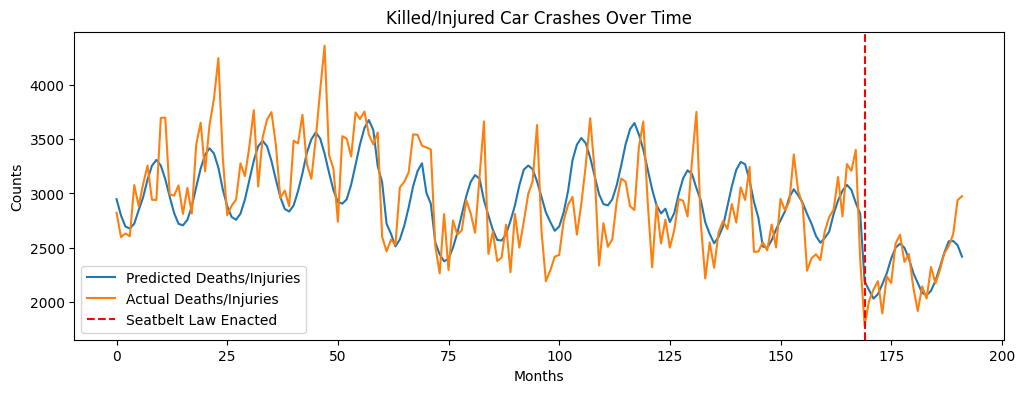

In [24]:
p4a = fit4.draws_pd()['alpha'].mean()
p4b1 = fit4.draws_pd()['beta[1]'].mean()
p4b2 = fit4.draws_pd()['beta[2]'].mean()
p4b3 = fit4.draws_pd()['beta[3]'].mean()
p4b4 = fit4.draws_pd()['beta[4]'].mean()

y4 = np.exp(p4a + p4b1 * road_trig['PetrolPrice'] + p4b2 * road_trig['law'] + p4b3 * road_trig['cos'] + p4b4 * road_trig['sin'])
plt.figure(figsize=(12,4))
plt.plot(y4, label='Predicted Deaths/Injuries')
plt.plot(accidents, label='Actual Deaths/Injuries')
plt.axvline(x=169, color='red', linestyle='--', label='Seatbelt Law Enacted')
plt.legend()
plt.title('Killed/Injured Car Crashes Over Time')
plt.xlabel('Months')
plt.ylabel('Counts')
plt.show()

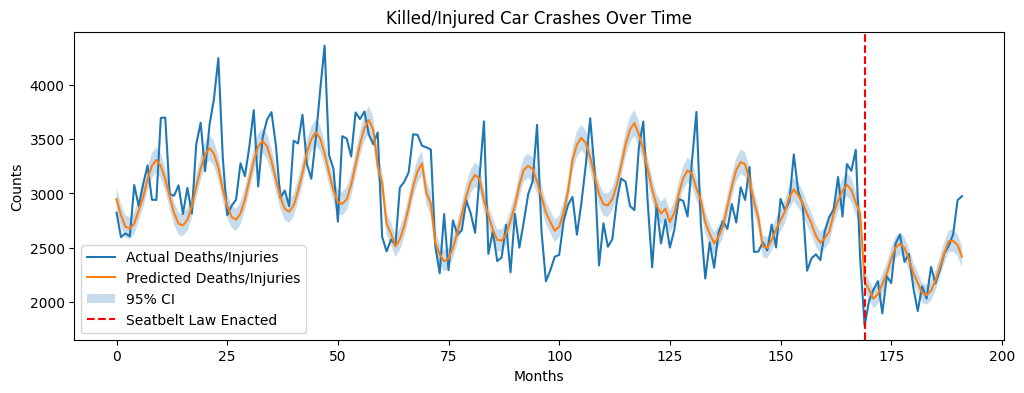

In [25]:
pred4 = fit4.stan_variable('y_tilde')
pred4_mean = pred4.mean(axis=0)
pred4_lower = np.percentile(pred4, 2.5, axis=0) #got this idea from Sarah in the office hours
pred4_upper = np.percentile(pred4, 97.5, axis=0) #figured I should do something to make use of doing it with stan

plt.figure(figsize=(12,4))
plt.plot(accidents, label='Actual Deaths/Injuries')
plt.plot(pred4_mean, label='Predicted Deaths/Injuries')
plt.fill_between(road_data['time']-1,pred4_lower, pred4_upper, alpha=0.25, label='95% CI') 
plt.axvline(x=169, color='red', linestyle='--', label='Seatbelt Law Enacted')
plt.legend(loc='lower left')
plt.title('Killed/Injured Car Crashes Over Time')
plt.xlabel('Months')
plt.ylabel('Counts')
plt.show()

This fits decently well. The summary table shows all $\hat{R}\$s are less than 1.01 and the credible intervals are there too. There are a number of betas that come close to 0, but none of the credible intervals contain 0, though beta 3 has some points that cross over. All present with fuzzy caterpillars. This one looks much like a trig curve, so while it does capture the up and down nature, it's more curved and therefore loses some of the nuance in the motion. This model also portrays a sharp decline near the setabelt law enactment. Once again this plot was done without (the first one) and with (the second one) using stan to generate the posterior predictive. 

## Problem 5:

We should also discuss **offsets** which is another trick you can use in Poisson regression. 

In Poisson regression, we estimate the varying $\lambda$. This is the average number of occurences of a count. Each row has a different average depending on what that row's predictors are.

However, sometimes one is interested or compelled to estimate a *rate*. 

A rate can be thought of as an average count **per unit of something else.** It can be average count *per unit time* or average count *per unit space* or something else. Then there is a simple transformation you can make to your model that will allow a Poisson regression to be employed. 

Let's suppose we are interest in estimating $\lambda / \text{time}$. Suppose $\text{time}$ is different for each row, and that's why we want to take it into account. 


If 
$$
\log\left(\frac{\lambda}{\text{time}}\right) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 
$$

then

$$
\log\left(\lambda\right) = \log(\text{time}) + \beta_0 + \beta_1 x_1 + \beta_2 x_2 
$$

So, an **offset is a predictor that has a forced coefficient of $1$**.

NB: We aren't going to use time in our problem below--because every row has the same amount of time: one month--but this is just an assumption for my explanation.  


Fit the following model to estimate the average rate of accidents **per kilometer driven**. Discuss the posterior you found in detail. Comment on whether ommitting any time predictors is stil problematic with this offset. Also comment on whether the two original predictors are still deserving enough to be included.



$$
\log\left(\frac{\lambda}{\text{kms}}\right) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 
$$


 - $y$ is the monthly sum of `drivers`, `front`, and `rear`.
 - $x_1$ is `PetrolPrice`
 - $x_2$ is the `law` dummy variable
 - $\text{kms}$ is an offset relating to the `kms` column


In [26]:
road_data['log_kms'] = np.log(road_data['kms'])
road_offset = road_data[['PetrolPrice', 'law', 'log_kms']]
road_offset.head()

,PetrolPrice,law,log_kms
0,0.102972,0,9.111514
1,0.102363,0,8.947026
2,0.102062,0,9.206634
3,0.100873,0,9.301551
4,0.101020,0,9.377802


In [27]:
road_data['log_kms'] = np.log(road_data['kms'])
road_offset = road_data[['log_kms']]
road_offset = road_offset.to_numpy().flatten()
road_offset.shape

(192,)

In [28]:
model_code_offset = os.path.join('.', 'poisson_log_offset.stan')
model_offset = CmdStanModel(stan_file=model_code_offset)

In [29]:
p5_data = {'N': road_simp.shape[0], 'K': road_simp.shape[1], 'X': road_simp, 'y': accidents, 'off': road_offset}
fit5 = model_offset.sample(data = p5_data)

21:46:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:46:24 - cmdstanpy - INFO - CmdStan done processing.


In [30]:
fit5.summary().iloc[0:4]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,3.888800e+06,0.112040,4.772640,3.888800e+06,3.888800e+06,3.888810e+06,1814.560,1253.150,1.00325
alpha,-7.181490e-01,0.000426,0.011702,-7.369190e-01,-7.180150e-01,-6.993810e-01,753.906,520.653,1.00015
beta[1],-8.425820e+00,0.004217,0.115092,-8.611580e+00,-8.428310e+00,-8.241850e+00,744.853,514.402,1.00002
beta[2],-4.059240e-01,0.000123,0.004801,-4.137560e-01,-4.060440e-01,-3.977750e-01,1519.120,1049.120,1.00122


Text(0.5, 1.0, 'beta 2')

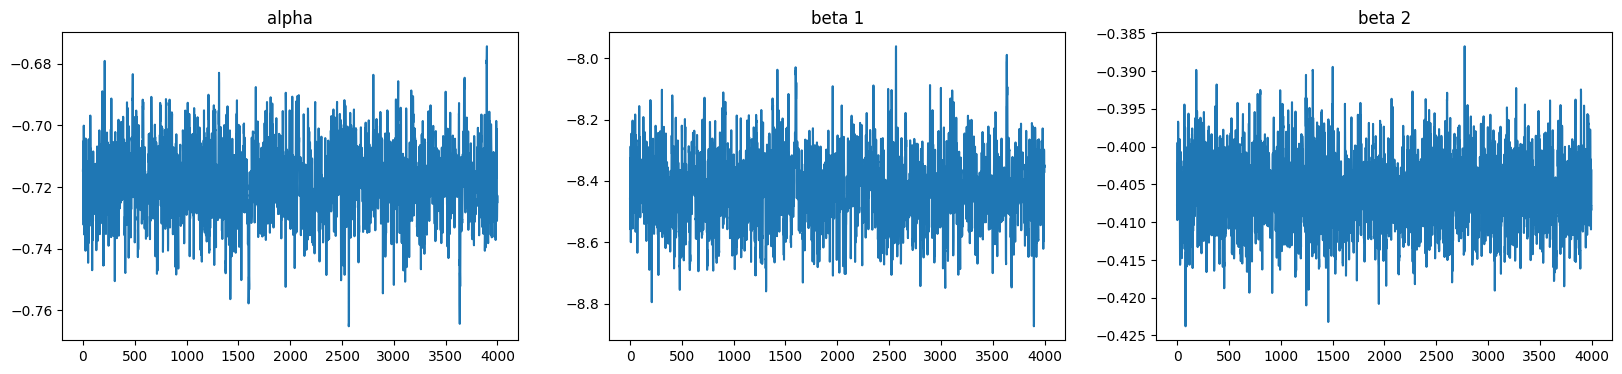

In [31]:
fig5, (p5a, p5b1, p5b2) = plt.subplots(1, 3, figsize=(20,4))

p5a.plot(fit5.draws_pd()['alpha'])
p5a.set_title('alpha')

p5b1.plot(fit5.draws_pd()['beta[1]'])
p5b1.set_title('beta 1')

p5b2.plot(fit5.draws_pd()['beta[2]'])
p5b2.set_title('beta 2')

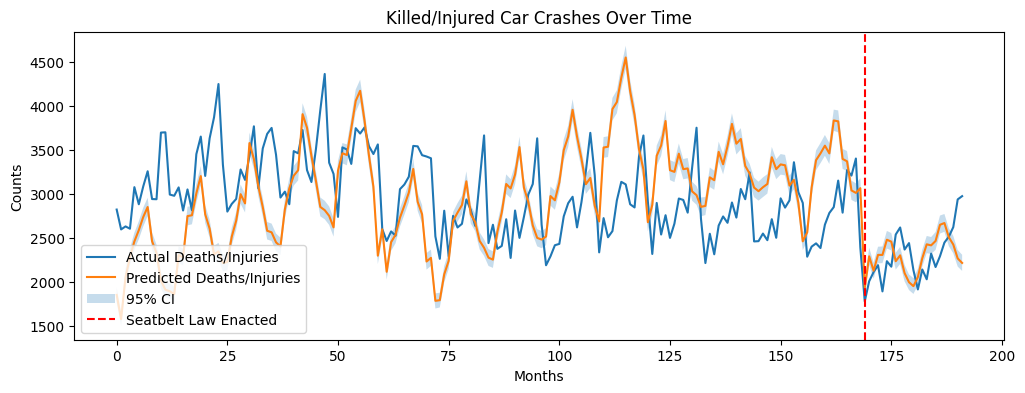

In [32]:
pred5 = fit5.stan_variable('y_tilde')
pred5_mean = pred5.mean(axis=0)
pred5_lower = np.percentile(pred5, 2.5, axis=0) #got this idea from Sarah in the office hours
pred5_upper = np.percentile(pred5, 97.5, axis=0) #figured I should do something to make use of doing it with stan

plt.figure(figsize=(12,4))
plt.plot(accidents, label='Actual Deaths/Injuries')
plt.plot(pred5_mean, label='Predicted Deaths/Injuries')
plt.fill_between(road_data['time']-1, pred5_lower, pred5_upper, alpha=0.25, label='95% CI') 
plt.axvline(x=169, color='red', linestyle='--', label='Seatbelt Law Enacted')
plt.legend(loc='lower left')
plt.title('Killed/Injured Car Crashes Over Time')
plt.xlabel('Months')
plt.ylabel('Counts')
plt.show()

This fits decently well. The summary table shows all $\hat{R}\$s are less than 1.01 and the credible intervals are there too. There are a number of betas that come close to 0, but none of the credible intervals contain 0. All present with fuzzy caterpillars. This does portray an up and down nature of the data, but seems to miss more than it hits. This model also portrays a sharp decline near the setabelt law enactment. This plot only uses stan to generate the posterior predictive.

## Problem 6:

Recommend a final model that is a revisement of the previous model. Estimate it in `stan` and discuss the posterior in detail. Comment on whether you believe the seat belt law has an effect!



In [33]:
p61_data = {'N': road_month.shape[0], 'K': road_month.shape[1], 'X': road_month, 'y': accidents, 'off': road_offset}
fit61 = model_offset.sample(data = p61_data)

21:46:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:46:38 - cmdstanpy - INFO - CmdStan done processing.


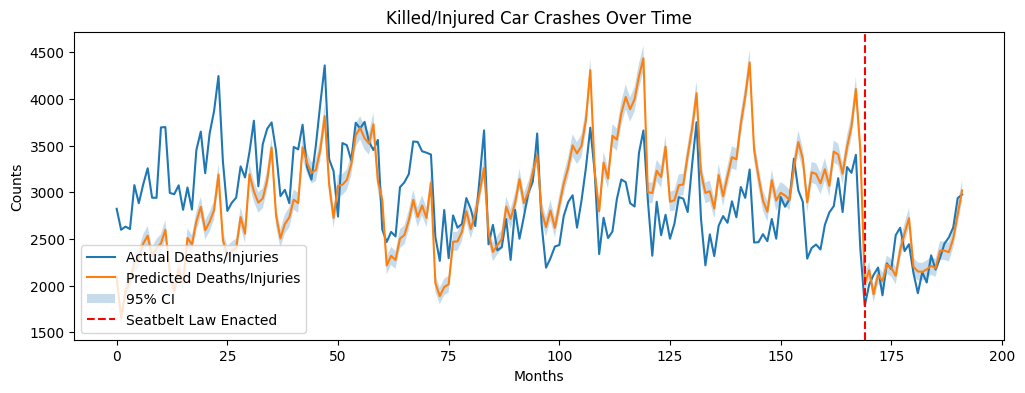

In [34]:
pred61 = fit61.stan_variable('y_tilde')
pred61_mean = pred61.mean(axis=0)
pred61_lower = np.percentile(pred61, 2.5, axis=0)
pred61_upper = np.percentile(pred61, 97.5, axis=0)

plt.figure(figsize=(12,4))
plt.plot(accidents, label='Actual Deaths/Injuries')
plt.plot(pred61_mean, label='Predicted Deaths/Injuries')
plt.fill_between(road_data['time']-1, pred61_lower, pred61_upper, alpha=0.25, label='95% CI') 
plt.axvline(x=169, color='red', linestyle='--', label='Seatbelt Law Enacted')
plt.legend(loc='lower left')
plt.title('Killed/Injured Car Crashes Over Time')
plt.xlabel('Months')
plt.ylabel('Counts')
plt.show()

In [35]:
road_petrol = road_data[['PetrolPrice']]

In [36]:
p62_data = {'N': road_petrol.shape[0], 'K': road_petrol.shape[1], 'X': road_petrol, 'y': accidents}
fit62 = model.sample(data = p62_data)

21:47:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:47:07 - cmdstanpy - INFO - CmdStan done processing.


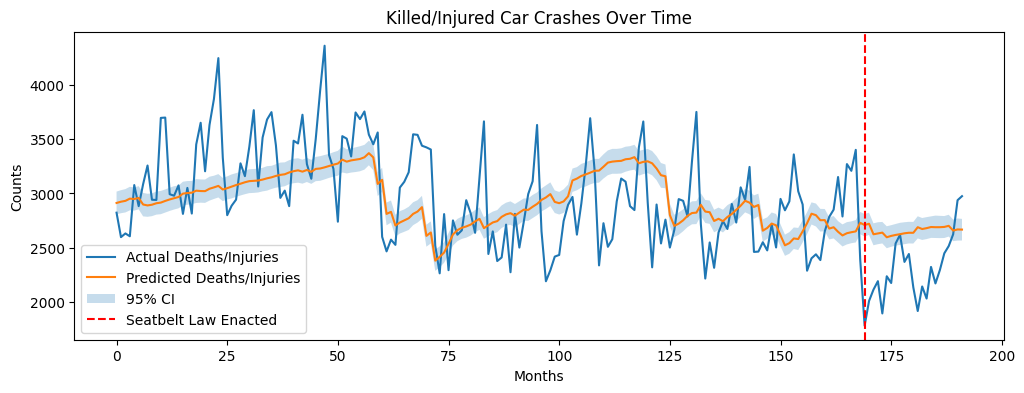

In [37]:
pred62 = fit62.stan_variable('y_tilde')
pred62_mean = pred62.mean(axis=0)
pred62_lower = np.percentile(pred62, 2.5, axis=0) #got this idea from Sarah in the office hours
pred62_upper = np.percentile(pred62, 97.5, axis=0) #figured I should do something to make use of doing it with stan

plt.figure(figsize=(12,4))
plt.plot(accidents, label='Actual Deaths/Injuries')
plt.plot(pred62_mean, label='Predicted Deaths/Injuries')
plt.fill_between(road_data['time']-1, pred62_lower, pred62_upper, alpha=0.25, label='95% CI') 
plt.axvline(x=169, color='red', linestyle='--', label='Seatbelt Law Enacted')
plt.legend(loc='lower left')
plt.title('Killed/Injured Car Crashes Over Time')
plt.xlabel('Months')
plt.ylabel('Counts')
plt.show()

In [38]:
p63_data = {'N': road_petrol.shape[0], 'K': road_petrol.shape[1], 'X': road_petrol, 'y': accidents, 'off': road_offset}
fit63 = model_offset.sample(data = p63_data)

21:47:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:47:18 - cmdstanpy - INFO - CmdStan done processing.


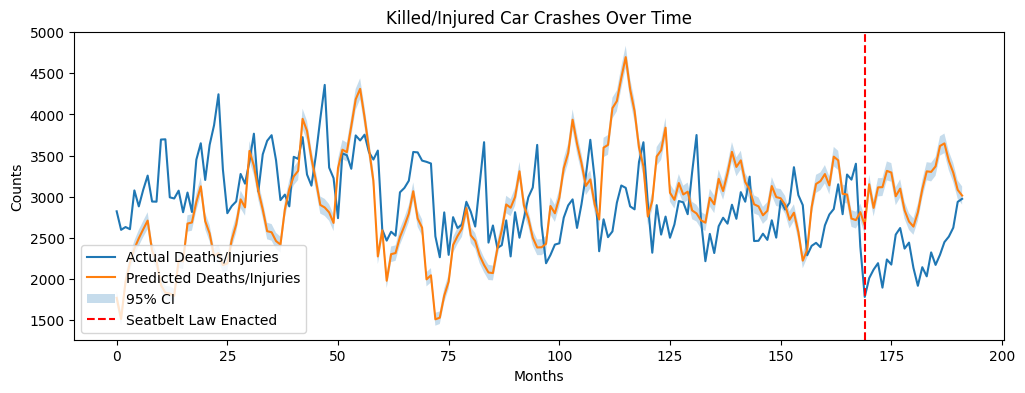

In [39]:
pred63 = fit63.stan_variable('y_tilde')
pred63_mean = pred63.mean(axis=0)
pred63_lower = np.percentile(pred63, 2.5, axis=0) #got this idea from Sarah in the office hours
pred63_upper = np.percentile(pred63, 97.5, axis=0) #figured I should do something to make use of doing it with stan

plt.figure(figsize=(12,4))
plt.plot(accidents, label='Actual Deaths/Injuries')
plt.plot(pred63_mean, label='Predicted Deaths/Injuries')
plt.fill_between(road_data['time']-1, pred63_lower, pred63_upper, alpha=0.25, label='95% CI') 
plt.axvline(x=169, color='red', linestyle='--', label='Seatbelt Law Enacted')
plt.legend(loc='lower left')
plt.title('Killed/Injured Car Crashes Over Time')
plt.xlabel('Months')
plt.ylabel('Counts')
plt.show()

In [40]:
road_month_nolaw = road_month.drop('law', axis=1)

In [41]:
p64_data = {'N': road_month_nolaw.shape[0], 'K': road_month_nolaw.shape[1], 'X': road_month_nolaw, 'y': accidents}
fit64 = model.sample(data = p64_data)

21:47:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:47:30 - cmdstanpy - INFO - CmdStan done processing.


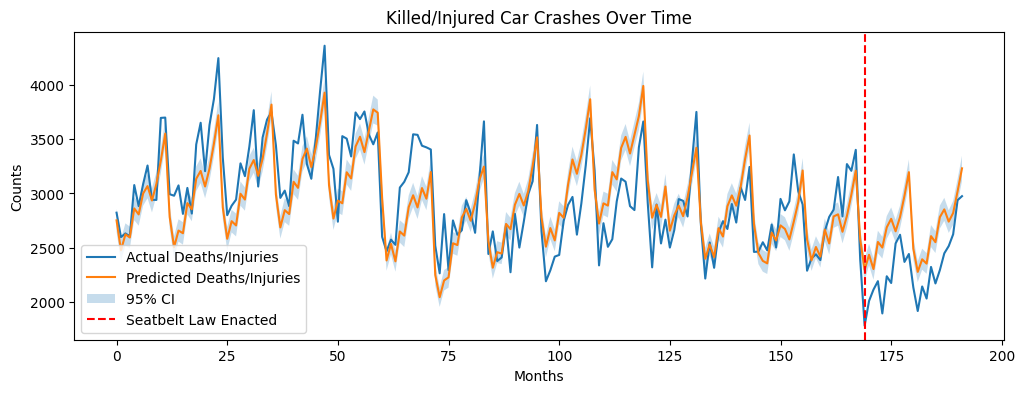

In [42]:
pred64 = fit64.stan_variable('y_tilde')
pred64_mean = pred64.mean(axis=0)
pred64_lower = np.percentile(pred64, 2.5, axis=0) #got this idea from Sarah in the office hours
pred64_upper = np.percentile(pred64, 97.5, axis=0) #figured I should do something to make use of doing it with stan

plt.figure(figsize=(12,4))
plt.plot(accidents, label='Actual Deaths/Injuries')
plt.plot(pred64_mean, label='Predicted Deaths/Injuries')
plt.fill_between(road_data['time']-1, pred64_lower, pred64_upper, alpha=0.25, label='95% CI') 
plt.axvline(x=169, color='red', linestyle='--', label='Seatbelt Law Enacted')
plt.legend(loc='lower left')
plt.title('Killed/Injured Car Crashes Over Time')
plt.xlabel('Months')
plt.ylabel('Counts')
plt.show()

In [43]:
fit64.summary().iloc[0:14]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,3.900400e+06,0.048015,2.329330,3.900400e+06,3.900400e+06,3.900400e+06,2353.440,2084.540,1.00208
alpha,8.613130e+00,0.000420,0.012411,8.592740e+00,8.613250e+00,8.633560e+00,873.842,773.996,1.00093
beta[1],-6.726770e+00,0.003142,0.111013,-6.911300e+00,-6.726270e+00,-6.547950e+00,1248.130,1105.520,1.00011
beta[2],-1.096170e-01,0.000224,0.006947,-1.210210e-01,-1.096600e-01,-9.799870e-02,960.793,851.013,1.00266
beta[3],-5.411140e-02,0.000211,0.006822,-6.555890e-02,-5.419890e-02,-4.269890e-02,1045.880,926.373,1.00214
beta[4],-7.306320e-02,0.000212,0.006887,-8.432020e-02,-7.312630e-02,-6.161350e-02,1055.050,934.501,1.00094
beta[5],2.509170e-02,0.000208,0.006585,1.414740e-02,2.499900e-02,3.588150e-02,998.032,883.997,1.00172
beta[6],3.560280e-03,0.000220,0.006714,-7.749290e-03,3.742240e-03,1.427960e-02,931.263,824.856,1.00275
beta[7],9.148720e-02,0.000211,0.006644,8.064750e-02,9.137100e-02,1.021710e-01,987.951,875.067,1.00220
beta[8],1.153300e-01,0.000209,0.006558,1.045110e-01,1.153990e-01,1.260670e-01,987.004,874.229,1.00174


I tried this a bunch of different ways. I noticed in problems 2-5 that at the law enactment there is a sharp decline in accidents. I also noticed that problem 3, the problem with all the months, the posterior seemed to fit the data the best. So first I tried to fit the month model with an offset, but that didn't seem to work out so well. Then I retried problem 2 without the law predictor to see how that would do, but that did terribly (I forgot that's why we did problems 3-5!). So I fitted it with an offset and that did better, but still seemed off. It did however show that it predicted more accidents after the law. Last I tried the month data without the law predictor (no offset). It faired similarly as before before the law enactment, but the overpredicted after the law enactment. This seems to suggest that the law did have an effect on the accidents, since the model with the law predictor did a decent job of predicting both before and after the seatbelt law enactment. All the $\hat{R}\$ are less than 1.01, but I did not graph the fuzzy caterpillars this time. 